### General Usage Example for the `optimex` Package

`optimex` (Optimization of Time-Explicit LCA) is a Python package designed to help identify 
transition pathways of systems with multiple processes producing the same product. 
It enables selecting the optimal process portfolio over time to minimize environmental impact.

This package leverages **Brightway**, a widely-used framework for Life Cycle Assessment (LCA), to perform environmental impact calculations.

Before using `optimex`, you need to set up a Brightway project. Brightway manages LCA databases, calculates impacts, and allows detailed environmental analysis.

You can learn more about Brightway and its installation here:  
[Brightway LCA Framework](https://docs.brightway.dev/en/latest/)

In [1]:
from datetime import datetime
import numpy as np
import bw2data as bd
from bw_temporalis import TemporalDistribution

# Set the project (creates it if not existing)
bd.projects.set_current("basic_usage_example")

### Required Brightway Databases: Biosphere

`optimex` requires a biosphere database collecting elementary flows, typically imported from databases like ecoinvent. Here, we create a minimal custom biosphere database named **biosphere3**, which is the standard name expected by `optimex`.

We also specify CAS numbers for flows explicitly, which will assist in later characterization steps.


In [2]:

# BIOSPHERE
biosphere_data = {
    ("biosphere3", "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "CAS number": "000124-38-9"
    },
    ("biosphere3", "CH4"): {
        "type": "emission",
        "name": "methane, fossil",
        "CAS number": "000074-82-8"
    },
}
bd.Database("biosphere3").write(biosphere_data)

100%|██████████| 2/2 [00:00<?, ?it/s]


12:11:56+0200 [info     ] Vacuuming database            


### Required Databases: Foreground

When conducting a Life Cycle Assessment (LCA) using `optimex`, it is essential to divide your system into two parts:

- **Foreground system**: This includes your own custom-designed processes. Here, you define processes you want to optimize and analyze over time.  
- **Background system**: This consists of intermediate or external processes sourced from existing LCA databases, used as inputs to the foreground processes.

Time-Explicit Modeling in the Foreground

`optimex` extends traditional LCA by explicitly modeling time, allowing you to separate the **installation** and **operation** phases of each process. This temporal detail provides greater flexibility and accuracy at moddeling real-life processes.

For example, consider a process `P1` that produces a product `F1` over a 4-year lifecycle:

- **Year 0 (Pre-operation)**: The process is installed (constructed). It does not produce any output but consumes an input `I1`.  
- **Years 1 and 2 (Operation phase)**: The process produces 0.5 units of `F1` each year and emits CO₂ accordingly.  
- **Year 3 (Post-operation)**: The process is decommissioned and does not exchange anything.

To enable this functionality we explictly need to tell `optimex` the time limits of the operation phase for each process.
Additionally, flows that vary in magnitude depending on the level of operation (e.g., production output, emissions during operation) need to be marked with 
```python
"operation": True

In [3]:

# FOREGROUND - temporally distributed
foreground_data = {
    ("foreground", "P1"): {
        "name": "process P1",
        "location": "somewhere",
        "reference product": "F1",
        "operation_time_limits": (1,2), # Optimex-specific: start and end year of operation phase
        "exchanges": [
            {
                "amount": 1,
                "type": "production",
                "input": ("foreground", "P1"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True, # Optimex-specific: indicates that this exchange is part of the operation phase
            },
            {
                "amount": 27.5,
                "type": "technosphere",
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": "biosphere",
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P2"): {
        "name": "process P2",
        "location": "somewhere",
        "reference product": "F1",
        "operation_time_limits": (1,2),
        "exchanges": [
            {
                "amount": 1,
                "type": "production",
                "input": ("foreground", "P2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": "technosphere",
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": "biosphere",
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
}
fg = bd.Database("foreground")
fg.write(foreground_data)
fg.register()

12:11:56+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


12:11:56+0200 [info     ] Vacuuming database            


### Required Databases: Background

The **background system** represents the surrounding technical environment that supports but is **not influenced** by the foreground system (e.g., electricity supply, raw material production). Although we cannot control these processes, they **change over time** due to technological progress or policy shifts.

Time-Variant Modeling: To reflect this, define **multiple background databases** at different time points (e.g., 2020, 2030, 2040). `optimex` will link the appropriate background based on each process’s timeline.

For `optimex` to recognize the representative time of each background version, store the date in the database metadata:


In [4]:

# BACKGROUND 2020
db_2020_data = {
    ("db_2020", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I1")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2020", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I2")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2020 = bd.Database("db_2020")
bg_2020.write(db_2020_data)
bg_2020.metadata["representative_time"] = datetime(2020, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2020.register()

# BACKGROUND 2030
db_2030_data = {
    ("db_2030", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I1")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2030", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I2")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2030 = bd.Database("db_2030")
bg_2030.write(db_2030_data)
bg_2030.metadata["representative_time"] = datetime(2030, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2030.register()


12:11:57+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


12:11:57+0200 [info     ] Vacuuming database            
12:11:57+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


12:11:57+0200 [info     ] Vacuuming database            


### Characterization Methods

To quantify environmental impact, we need to define **characterization factors** (CFs) for each elementary flow—such as CO₂ or CH₄ emissions. These CFs convert emissions into impact scores (e.g., in kg CO₂-eq).

> 🔎 Note: If you're using a full database like **ecoinvent**, characterization methods (e.g. IPCC, ReCiPe) are usually already included.  
> But since we're creating a custom biosphere here, we need to define our own CFs manually.


In [5]:
bd.Method(("GWP", "example")).write([
    (("biosphere3", "CO2"), 1),
    (("biosphere3", "CH4"), 27),
])

bd.Method(("land use", "example")).write([
    (("biosphere3", "CO2"), 2),
    (("biosphere3", "CH4"), 1),
])

### Defining Demand and Functional Flows in `optimex`

Before we can process our LCA data in `optimex`, two key elements must be defined:  

1. Temporal Demand

The demand describes how much of the functional product (e.g., `"F1"`) is needed each year across the time horizon of interest. This is defined using a `TemporalDistribution`, which allows you to assign specific demand values to individual years.

By explicitly modeling how demand changes over time, `optimex` can optimize not only which processes to use but also when to install and operate them. This enables more realistic and flexible system planning.


2. Marking Functional Flows

Once the demand is defined, we must indicate which foreground processes are capable of fulfilling it. This is done by labeling them with a `"functional_flow"` field that matches the name of the product being demanded (e.g., `"F1"`).

Only processes marked this way will be considered by `optimex` when attempting to meet the specified demand. This step is essential to link the demand to the available supply options.


In [6]:
# Define temporally distributed demand from 2020 to 2030
years = range(2020, 2030)
td_demand = TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype='datetime64[s]'),
    amount=np.asarray([0, 0, 10, 5, 10, 5, 10, 5, 10, 5]),
)

# For optimex to work, we need to manually define which processes  produce desired 
# products labeled as functional flows
foreground = bd.Database("foreground")
for act in foreground:
    act["functional_flow"] = "F1"
    act.save()


### Dynamic Characterization in `optimex`

One of the key advantages of `optimex` is its ability to perform **dynamic characterization**—assessing environmental impacts in a way that accounts for **when emissions occur**, not just how much is emitted. This is particularly relevant for impact categories like **climate change**, where timing significantly influences the outcome.

*Why Use Dynamic Characterization?*

In conventional (static) LCA, the timing of emissions is ignored—1 kg of CO₂ emitted today is treated the same as 1 kg emitted 50 years from now.  
Dynamic characterization allows `optimex` to differentiate these cases by using **time-resolved impact factors**, giving a more accurate picture of long-term environmental effects.

Currently, `optimex` supports dynamic modeling for climate change through the following metrics:

- **CRF** – Cumulative Radiative Forcing  
- **GWP** – Global Warming Potential (time-sensitive)

These metrics are implemented via the [`dynamic_characterization`](https://github.com/brightway-lca/dynamic_characterization) package.

> 📌 Note: Only climate change metrics are currently supported for dynamic impact assessment.

### Requirements for Dynamic Use

To enable dynamic characterization in `optimex`, you must:

1. Specify a **supported dynamic metric** (e.g., `"CRF"` or `"GWP"`).
2. Define a **time horizon** for impact assessment (e.g., 100 years).

If no metric is specified, `optimex` will default to **conventional static characterization** using standard impact factors.


In [7]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand = {"F1": td_demand},
    temporal= {
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": ("GWP", "example"),
            "metric": "CRF",
        },
        {
            "category_name": "land_use",
            "brightway_method": ("land use", "example"),
        },
    ],
    background_inventory={
        "cutoff": 1e4,
        "calculation_method": "sequential",
    },
)

With all the necessary components defined, we are now ready to **gather all LCA-relevant data** and prepare for optimization.

To summarize, we have:

- Defined a **custom biosphere** with elementary flows (e.g., CO₂, CH₄).
- Created **foreground** and **background** systems, including temporal distributions.
- Registered **characterization methods** (static or dynamic).
- Specified **demand over time** using `TemporalDistribution`.
- Marked processes as **functional flows** to indicate eligible supply routes.
- (Optionally) Enabled **dynamic characterization** for more time-sensitive impact assessment.

In [8]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-05-28 12:11:57.426 | INFO     | optimex.lca_processor:_parse_demand:321 - Identified demand in system time range of %s for functional flows %s
2025-05-28 12:11:57.435 | INFO     | optimex.lca_processor:_construct_foreground_tensors:446 - Constructed foreground tensors.
2025-05-28 12:11:57.436 | INFO     | optimex.lca_processor:log_tensor_dimensions:441 - Technosphere shape: (2 processes, 2 flows, 4 years) with 8 total entries.
2025-05-28 12:11:57.436 | INFO     | optimex.lca_processor:log_tensor_dimensions:441 - Biosphere shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-05-28 12:11:57.436 | INFO     | optimex.lca_processor:log_tensor_dimensions:441 - Production shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-05-28 12:11:57.436 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:484 - Calculating inventory for database: db_2020
2025-05-28 12:11:57.522 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:500 - Factorized LCI for 

### Saving and Reusing Model Inputs

Gathering all LCA-relevant data—including biosphere flows, foreground and background systems, temporal distributions, and characterization methods—can be **computationally expensive**.  
If you're working with similar scenarios or want to explore different optimization settings, it's often unnecessary to rebuild the entire setup from scratch.

 `OptimizationModelInputs`: Interface for Efficient Reuse

To address this, `optimex` provides a dedicated interface called **`OptimizationModelInputs`**. This object:

- Collects all the structured LCA data needed for optimization.
- Can be **saved** to disk for future use.
- Can be **loaded** later to resume or modify the scenario.
- Allows you to tweak configurations (e.g., demand, technologies, time horizon) without re-running the full data setup.

In the next steps, we’ll create and populate a `OptimizationModelInputs` object, and use it to prepare for running the optimization in `optimex`.

In [9]:
from optimex import converter
manager = converter.ModelInputManager()
model_inputs = manager.parse_from_lca_processor(lca_data_processor)
# manager.save("model_inputs.json")
# manager.load("model_inputs.json")
model_inputs.model_dump()


{'PROCESS': ['P2', 'P1'],
 'FUNCTIONAL_FLOW': ['F1'],
 'INTERMEDIATE_FLOW': ['I2', 'I1'],
 'ELEMENTARY_FLOW': ['CO2', 'CH4'],
 'BACKGROUND_ID': ['db_2020', 'db_2030'],
 'PROCESS_TIME': [0, 1, 2, 3],
 'SYSTEM_TIME': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029],
 'CATEGORY': ['land_use', 'climate_change'],
 'demand': {('F1', 2020): 0.0,
  ('F1', 2021): 0.0,
  ('F1', 2022): 10.0,
  ('F1', 2023): 5.0,
  ('F1', 2024): 10.0,
  ('F1', 2025): 5.0,
  ('F1', 2026): 10.0,
  ('F1', 2027): 5.0,
  ('F1', 2028): 10.0,
  ('F1', 2029): 5.0},
 'operation_flow': {('P2', 'F1'): True,
  ('P2', 'CO2'): True,
  ('P1', 'F1'): True,
  ('P1', 'CO2'): True},
 'foreground_technosphere': {('P2', 'I2', 0): 1.0,
  ('P2', 'I2', 1): 0.0,
  ('P2', 'I2', 2): 0.0,
  ('P2', 'I2', 3): 0.0,
  ('P1', 'I1', 0): 27.5,
  ('P1', 'I1', 1): 0.0,
  ('P1', 'I1', 2): 0.0,
  ('P1', 'I1', 3): 0.0},
 'foreground_biosphere': {('P2', 'CO2', 0): 0.0,
  ('P2', 'CO2', 1): 10.0,
  ('P2', 'CO2', 2): 10.0,
  ('P2', 'CO2', 3): 0.

### Creating the Optimization Model

With the `OptimizationModelInputs` object prepared, we can now **populate the optimization model** in `optimex`.

This step involves specifying:

- A **name** for the model,
- The **impact category** to be minimized (e.g., `"climate_change"`),
- Whether to enable **flexible operation** (i.e., allow processes to run at varying capacity over time).

Flexible operation is particularly useful in time-explicit LCA, as it allows the model to install a capacity once and operate it differently across its lifespan—offering more realistic and optimized transition pathways.



In [10]:
from optimex import optimizer

model = optimizer.create_model(
    model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

2025-05-28 12:11:58.913 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-05-28 12:11:58.915 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-05-28 12:11:58.915 | INFO     | optimex.optimizer:create_model:272 - Creating variables


## Solving the Optimization Model

Once the model is created, you can solve it using available solvers such as **GLPK** or **Gurobi**.

Use the `solve_model` function from `optimex` to run the optimization. It offers several parameters to control solver options, convergence criteria, and output verbosity.

For detailed information on all parameters and solver configurations, please refer to the documentation.

In [11]:
m, obj, results = optimizer.solve_model(model, tee=False)

2025-05-28 12:11:59.203 | INFO     | optimex.optimizer:solve_model:601 - Solver [gurobi] termination: optimal
2025-05-28 12:11:59.210 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 4.33081
2025-05-28 12:11:59.211 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   2.81685e-10


## Postprocessing the Optimization Results

`optimex` offers powerful tools to analyze and visualize the optimal solution in detail. Key aspects you can explore include:

- **Impact over time:** View time-resolved environmental impacts according to the chosen impact category.
- **Demand fulfillment:** Track how the demand for the functional product evolves and is met throughout the modeled period.
- **Installation timeline:** Identify when each process was installed during the transition pathway.
- **Operation profiles:** Examine the operational levels of processes year-by-year, especially important for flexible operation scenarios.
- **Production of functional flows:** Analyze how much of the functional product each process produces over time.

Together, these outputs provide a comprehensive understanding of the system’s dynamics, helping you evaluate trade-offs and the timing of interventions.


In [13]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

df_impact = pp.get_impacts()
df_impact

Category land_use              climate_change              
Process        P2           P1             P2            P1
Time                                                       
2020          0.0     0.000000   0.000000e+00  0.000000e+00
2021         19.8     0.000000   4.682937e-11  0.000000e+00
2022        400.0     0.000000   1.743223e-11  0.000000e+00
2023        219.4     0.000000   5.452696e-11  0.000000e+00
2024        400.0     0.000000   1.715036e-11  0.000000e+00
2025        200.0  1044.999987   8.504451e-12  4.443576e-11
2026          0.0   400.000000   0.000000e+00  1.686709e-11
2027          0.0  1222.999982   0.000000e+00  5.113645e-11
2028          0.0   400.000000   0.000000e+00  1.658239e-11
2029          0.0   200.000000   0.000000e+00  8.219740e-12

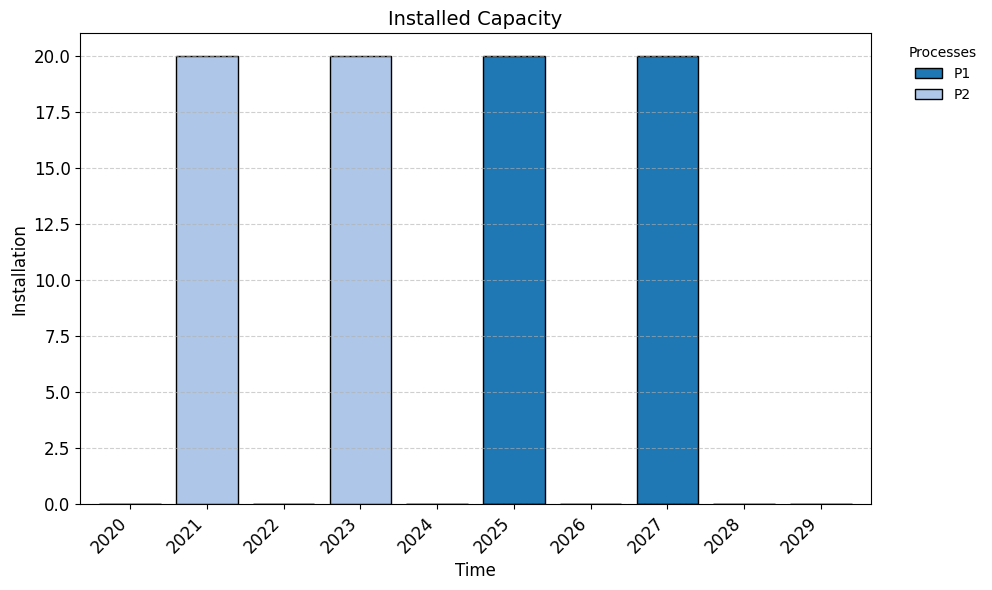

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [15]:
pp.plot_installation()


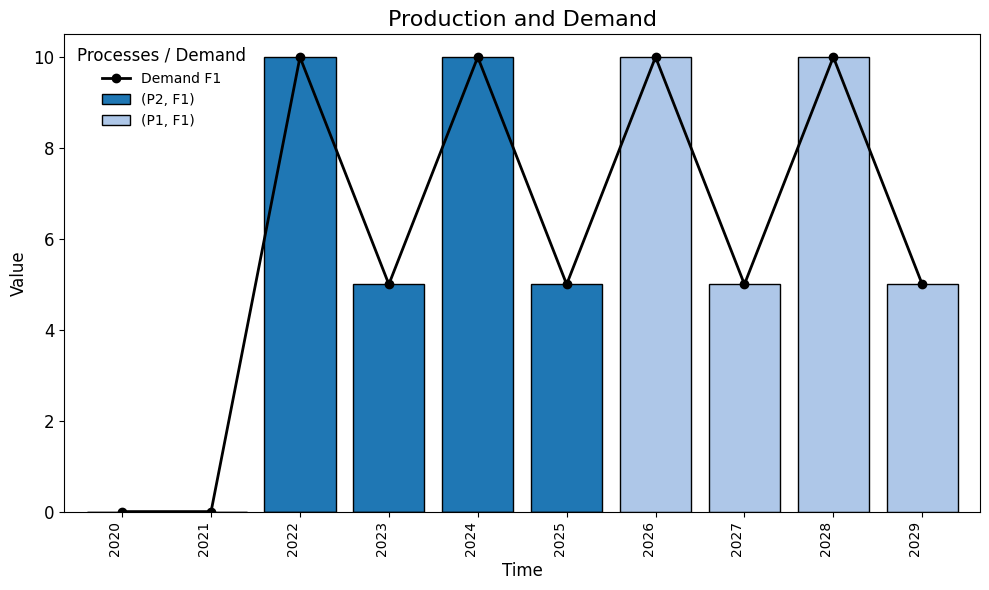

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Value'>)

In [16]:
pp.plot_production_and_demand()